In [7]:
## This script computes VerbNet pairwise sentence similarities
# Requires that sentences have already been parsed using VerbNet semantic roles, as performed by 'Calc_parse_GPT4.ipynb'.
# Run using base python 3.9
# James Fodor 2023

# load libraries
import numpy as np
import json
import warnings
import itertools
import sentence_embeds_processing as sep
import seaborn as sns
import matplotlib.pyplot as plt

# load file paths
with open("file_paths.json", "r") as file:
    file_paths_dict = json.load(file)

# set fixed params
role_weights_fixed_dict = {'Agent':2, 'Verb':3, 'Patient':2, 'Theme':2, 'Time':0.5, 'Manner':0.5, 'Location':0.5, 'Trajectory':0.5}
# these are from the test-train regression using STS3k data
role_weights_ST3k_dict = {'Agent':0.22, 'Verb':0.19, 'Patient':0.13, 'Theme':0.14, 'Time':0.03, 'Manner':0.03, 'Location':0.12, 'Trajectory':0.10}
role_weights_dict_of_dicts = {'fixed':role_weights_fixed_dict, 'STS3k':role_weights_ST3k_dict, 'struct':role_weights_fixed_dict}

# numpy print options
np.set_printoptions(precision=4, threshold=2000, linewidth=200, suppress=True, floatmode='fixed')
sns.set()

# turn off annoying warning
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

# define stop words
stop_words = np.loadtxt(file_paths_dict['stop_words_path'], dtype='str') # list of stop words

In [3]:
## Functions to compute VerbNet rolewise similarities 

# Compute embedding for phrases from the verbnet parse using conceptnet
def get_conceptnet_embedding(conceptnet_embeds, phrase):
    
    # Split phrase into words and define storage
    word_list = sep.tokenise_sentence(phrase, stop_words)
    word_list = sep.replace_tricky_tokens(word_list)
    embed_length = len(conceptnet_embeds['man'])
    embeds = np.empty((0,embed_length), float)
    
    # Get word embeddings for each word in phrase
    for word in word_list:
        try:
            embeds = np.vstack([embeds,conceptnet_embeds[word.lower()]])
        except KeyError:
            continue # ignore words we can't find
    
    # Save final phrase embeddings
    if len(np.ndarray.flatten(embeds)) > embed_length: # deal with phrases with multiple embeddings
        phrase_embedding = np.mean(embeds, axis=0) # average over all saved embeddings
    else:
        try:
            phrase_embedding = embeds[0] # use embeddings for single word
        except IndexError:
            phrase_embedding = np.zeros(embed_length) # return array of zeros if no words in phrase found
    
    return phrase_embedding

# Calculate sentence embedding using sentbert
def get_sentbert_embedding(sentbert_model_mpnet, sentences):
    sentence_embeddings = sentbert_model_mpnet.encode(sentences, convert_to_tensor=True).reshape(-1)
    return np.array(sentence_embeddings)

# Calculate sentence embedding using defsent_cls
def get_defsent_cls_embedding(defsent_cls_model, sentence):
    embedding_model = defsent_cls_model.encode
    sentence_embeddings = defsent_cls_model.encode(sentence).reshape(-1)
    return np.array(sentence_embeddings)

# Calculate sentence embedding using amrbart
def get_amrbart_embedding(amrbart_model, amrbart_tokenizer, sentences):
    sentence_embeddings = np.empty((0,1024), float)
    for sentence in sentences:
        encoded_input = amrbart_tokenizer(sentence, return_tensors='pt')
        model_output = amrbart_model(**encoded_input)
        sentence_embedding = np.mean(model_output.encoder_last_hidden_state.detach().numpy()[0], axis=0)
        sentence_embeddings = np.vstack([sentence_embeddings, sentence_embedding])
    return sentence_embeddings[0]

# Get the embedding for a single phrase
def get_phrase_embedding(phrase, embed_type, embed_model):
    if embed_type=='conceptnet': # get embedding for phrase
        phrase_embed = get_conceptnet_embedding(embed_model, phrase)
    elif embed_type=='sentbert':
        phrase_embed = get_sentbert_embedding(embed_model, phrase)
    elif embed_type=='defsent_cls':
        phrase_embed = get_defsent_cls_embedding(embed_model, phrase)
    elif embed_type=='amrbart':
        phrase_embed = get_amrbart_embedding(embed_model[0], embed_model[1], phrase)
    return phrase_embed

# Get mean and std dev for a set of embeddings to use for normalisation
def get_all_rolewise_embeddings(sentences_parsed_dict, model_name, embed_model):

    # Embeddings length
    embed_length = get_phrase_embedding('man', model_name, embed_model).shape[0]

    # Get embeddings for each semantic role of each sentence
    all_embeds = []
    for sent_id in sentences_parsed_dict.keys():
        single_sentence_embed = []
        for sem_role in sentences_parsed_dict[sent_id][0].keys():
            sem_role_text = sentences_parsed_dict[sent_id][0][sem_role]
            if (sem_role_text != 'NONE'): # only if the corresponding semantic role is present
                single_sentence_embed.append(get_phrase_embedding(sem_role_text, model_name, embed_model))
            else: # if semantic role not present
                single_sentence_embed.append([np.NaN for x in np.arange(embed_length)]) # fill with nans
        all_embeds.append(single_sentence_embed)
    all_embeds = np.array(all_embeds)

    # Normalise embeddings
    all_embeds_flat = all_embeds.reshape(-1,embed_length) # combine embeddings of all roles and all sentences
    mean_embeds = np.nanmean(all_embeds_flat, axis=0) # mean for each dimension
    std_embeds = np.nanstd(all_embeds_flat, axis=0)+0.001 # std for each dimension
    all_embeds_flat_norml = (all_embeds_flat-mean_embeds)/std_embeds
    all_embeds_norml = all_embeds_flat_norml.reshape(all_embeds.shape) # put embeds back into structured form
    
    return all_embeds_norml

# Compute rolewise similarities for a pair of sentences
def calc_rolewise_sims(sent_id_pair, all_embeds_norml, sentences_parsed_dict, use_role_align, role_weights):
    
    # Define dictionary of pairs of semantic roles to align if no direct matches are present
    role_alignment_dict = [('Location','Trajectory'), ('Trajectory','Location'), ('Theme','Patient'), ('Patient','Theme'), ('Manner','Trajectory'), ('Trajectory','Manner')]

    # Get the sentence pair to compute similarity for
    sent_1_id = int(sent_id_pair[0])
    sent_2_id = int(sent_id_pair[1])
    sent_1_parsed = sentences_parsed_dict[str(sent_1_id)][0]
    sent_2_parsed = sentences_parsed_dict[str(sent_2_id)][0]

    # Define role sims storage dict
    role_sim_storage = {}
    
    # Loop over all semantic roles
    for role_id,role in enumerate(list(role_weights_fixed_dict.keys())):
        
        # If neither sentence has the role
        if sent_1_parsed[role]=='NONE' and sent_2_parsed[role]=='NONE':
            role_sim_storage[role] = np.NaN
            
        # If both sentences have the role
        elif sent_1_parsed[role]!='NONE' and sent_2_parsed[role]!='NONE':
            phrase_1_embed = all_embeds_norml[sent_1_id][role_id] # get role embeddings
            phrase_2_embed = all_embeds_norml[sent_2_id][role_id]
            role_sim_storage[role] = float(round(sep.cosine_sim(phrase_1_embed, phrase_2_embed),4))
            if role_weights=='struct':
                role_sim_storage[role]+=0.5
            
        # If one sentence has the role but the other does not
        else:
            role_sim_storage[role] = 0
            
    # Match related but distinct roles when there is no direct match
    if use_role_align==True:
        for role_match_1,role_match_2 in role_alignment_dict:
            if (sent_1_parsed[role_match_1]!='NONE' and sent_1_parsed[role_match_2]=='NONE') and (sent_2_parsed[role_match_1]=='NONE' and sent_2_parsed[role_match_2]!='NONE'):
                phrase_1_embed = all_embeds_norml[sent_1_id][role_id] # get role embeddings
                phrase_2_embed = all_embeds_norml[sent_2_id][role_id]
                role_sim_storage[role_match_1] = round(sep.cosine_sim(phrase_1_embed, phrase_2_embed),4)
                role_sim_storage[role_match_2] = np.NaN
                
    return role_sim_storage


# Function to convert role-wise dictionary sim storage into role-wise list storage
def dict_sim_to_list(role_weights_dict, sim_storage_dict):
    sim_storage_dict_full = {}
    for role in role_weights_dict.keys():
        try:
            sim_storage_dict_full[role] = sim_storage_dict[role]
        except KeyError:
            sim_storage_dict_full[role] = 0
    sim_storage_list = list(sim_storage_dict_full.values())
    
    return(sim_storage_list)


### Step 0: Load sentence dataset and parse

Load the dataset of sentences we want to compute VerbNet similarities for.

In [4]:
## Show available datasets, as specified in the sentence_embeds_processing module
pairs = False # specify if we are using paired data or list of sentences
if pairs==True:
    datasets = sep.available_pair_datasets
else:
    datasets = sep.available_nonpaired_datasets
for dataset in datasets.keys():
    print(dataset,datasets[dataset])

0 Wehbe_neuro
1 Anderson_neuro
2 Pereira243_neuro
3 Pereira384_neuro
4 Alice_neuro
5 Zhang_neuro
6 Fodor2024-final108_neuro


In [122]:
## Load sentence set into dictionary depending on type
dataset_name = datasets[5]
if pairs == True:
    sentences_dict = sep.load_set_of_sentences(dataset_name, file_paths_dict['data_pairs_path'], pairs)
else:
    sentences_dict = sep.load_set_of_sentences(dataset_name, file_paths_dict[dataset_name+'-stim'], pairs)
n = len(sentences_dict.keys()) # num sentences
print('\nloaded',dataset_name,'with',n,'sentences')


loaded Zhang_neuro with 95 sentences


In [123]:
## load parse data for the dataset
parse_type = 'GPT4' # choose parse type ('verbnet' or 'GPT4' or 'GPT4o)
json_path = file_paths_dict['parses_path']+parse_type+' Parsing\\'+dataset_name+'_parse-'+parse_type+'_mod.json'
sentences_parsed_dict = json.load(open(json_path)) # load verbnet parse data from json
sent_id_pairs = list(itertools.combinations(sentences_parsed_dict.keys(), 2))
n = len(sentences_parsed_dict.keys())
print('parse type:',parse_type)
print('sentences parsed:',n)

parse type: GPT4
sentences parsed: 95


### Step 1: Load embeddings models

In [124]:
## Load embeddings and transformer models for computing similarity

# Load ConceptNet embeddings
model_address = file_paths_dict['path_root']+'\\Word Embeddings\\ConceptNet Embeddings\\numberbatch-en.txt'
conceptnet_embeds = sep.import_word_model(model_address)
embed_length = get_conceptnet_embedding(conceptnet_embeds, 'man').shape[0]
print('Conceptnet embeds:',embed_length)

# Load SentBERT embeddings
from sentence_transformers import SentenceTransformer
sentbert_model_mpnet = SentenceTransformer(file_paths_dict['path_root']+'\\Sentence Encoders\\sentence-transformers-mpnet-base-v2')
embed_length = get_sentbert_embedding(sentbert_model_mpnet, ['man']).shape[0]
print('Sentbert embeds:',embed_length)

# Load DefSent models
from defsent import DefSent
defsent_cls_model = DefSent(file_paths_dict['path_root']+'\\Sentence Encoders\\defsent-roberta-large-cls')
embed_length = get_defsent_cls_embedding(defsent_cls_model, ['man']).shape[0]
print('Defsent embeds:',embed_length)

# Load AMRBART model
from transformers import AutoTokenizer, AutoConfig
from transformers import BartForConditionalGeneration
config_state = AutoConfig.from_pretrained(file_paths_dict['path_root']+'\\Sentence Encoders\\amrbart-large', output_hidden_states=True) # get hidden states
amrbart_tokenizer = AutoTokenizer.from_pretrained(file_paths_dict['path_root']+'\\Sentence Encoders\\amrbart-large', collapse_name_ops=False, use_pointer_tokens=True, raw_graph=False)
amrbart_model = BartForConditionalGeneration.from_pretrained(file_paths_dict['path_root']+'\\Sentence Encoders\\amrbart-large', config=config_state)

# Dictionary of all embedding models
dict_of_models = {'conceptnet':conceptnet_embeds, 'sentbert':sentbert_model_mpnet, 'defsent_cls':defsent_cls_model, 'amrbart':[amrbart_model,amrbart_tokenizer]}

Conceptnet embeds: 300
Sentbert embeds: 768
Defsent embeds: 1024


### Step 2: Compute rolewise similarities

In [147]:
## Compute role-wise sentence similarities using VerbNet semantic role parses

# Initialise storage 
all_role_sim_storage = {}
all_sim_storage_list = []

# Define parameters for calculating sentence sims
embed_type = 'conceptnet' # conceptnet, sentbert, defsent_cls, amrbart
role_weights = 'struct' # fixed, STS3k, struct
role_align = False

# Get embeddings for all semantic roles and all sentences
embed_model = dict_of_models[embed_type]
role_weights_dict = role_weights_dict_of_dicts[role_weights] # choose which set of semantic role weights to use
all_embeds_norml = get_all_rolewise_embeddings(sentences_parsed_dict, embed_type, embed_model)

# Loop over all sentence pairs to compute rolewise similarities
for idx,sent_id_pair in enumerate(sent_id_pairs):
   
    # Store in dictionary with all sentence pairs
    all_role_sim_storage[idx] = calc_rolewise_sims(sent_id_pair, all_embeds_norml, sentences_parsed_dict, role_align, role_weights)

    # Convert dictionary storage of rolewise sims into list and store
    sim_storage_list = dict_sim_to_list(role_weights_dict,all_role_sim_storage[idx])
    all_sim_storage_list.append(sim_storage_list)
    
# Save in json file
save_file_stem = dataset_name+"_parse-"+parse_type+"_embed-"+embed_type+"_weights-"+role_weights+"_align-"+str(int(role_align))+'_norml'
with open(file_paths_dict['parses_path']+"\\"+parse_type+" Parsing\\"+save_file_stem+"_rolesims.json", "w") as file:
    json.dump(all_role_sim_storage, file, indent=0)

### Step 3: Compute overall similarities

In [148]:
## Load stored rolewise sims into list

# load rolewise similarities file
json_rolewise_path = file_paths_dict['parses_path']+"\\"+parse_type+" Parsing\\"+save_file_stem+"_rolesims.json"
with open(json_rolewise_path, "r") as file:
    all_role_sim_storage = json.load(file)
    
# loop over all sentence pairs to load rolewise similarities
all_sim_storage_list = []
for idx,pair_id in enumerate(sent_id_pairs):
    # Convert dictionary storage of rolewise sims into list and store
    sim_storage_list = dict_sim_to_list(role_weights_dict,all_role_sim_storage[str(idx)])
    all_sim_storage_list.append(sim_storage_list)

In [149]:
## Compute overall VerbNet similarity

# Compute basic version of VerbNet-based similarities with the SAME normalisation applied to each sentence pair
all_sims_storage_np = np.array(all_sim_storage_list) 
role_weights_array = np.array(list(role_weights_dict.values())) # get role weights
all_sim_storage_list_nonan = np.ma.array(all_sims_storage_np, mask=np.isnan(all_sims_storage_np)) # ignore nan values
basic_similarities_non_norm = np.ma.dot(all_sim_storage_list_nonan, role_weights_array)
basic_similarities = basic_similarities_non_norm/np.sum(list(role_weights_dict.values())) # divide by total sum of weights

# Compute normalised VerbNet-based similarities, with each sentence normalised by ITS OWN length
rolewise_weights_masked = []
alt_similarities = []
i = 0
for pair_mask in all_sim_storage_list_nonan.mask:
    role_weights_array_masked = role_weights_array[~pair_mask] # need to invert the mask for the roles we want to keep
    total_length = np.sum(role_weights_array_masked) # get total weighted length of each sentence
    alt_similarities.append(basic_similarities_non_norm[i]/total_length) # normalise weights by total weight length
    i+=1

# Save results to files
save_file_name = file_paths_dict['sims_path']+save_file_stem+'_fixedparms_basic_similarities.txt'
np.savetxt(save_file_name, basic_similarities, fmt='%f')
save_file_name = file_paths_dict['sims_path']+save_file_stem+'_fixedparms_alt_similarities.txt'
np.savetxt(save_file_name, alt_similarities, fmt='%f')

### Step 4: Evaluate VerbNet Similarities

Plot a histograph of VerbNet rolewise similarities for evaluation of the distribution.

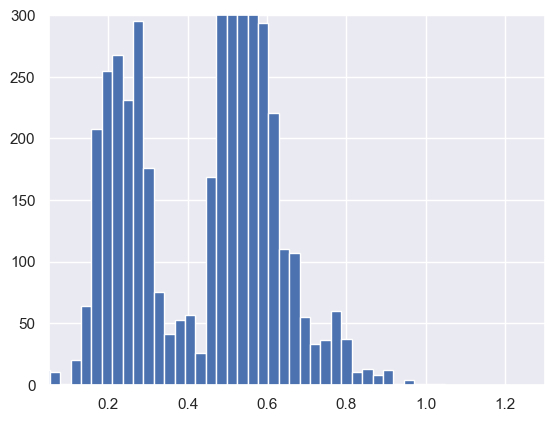

In [150]:
## Plot histogram of basic similarities
sns.set()
plt.hist(basic_similarities.data, bins=40)
# plt.hist(alt_similarities, bins=40)
plt.xlim(0.05,1.3)
plt.ylim(0,300)
plt.show()